In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN # 기본 RNN. 실제로는 사용X. LSTM, GRU등 사용

model = Sequential([
    SimpleRNN(3, input_shape=(2,10)) # 3: 은닉유닛 =3개, embedding dimention=10
]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 3)                 42        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


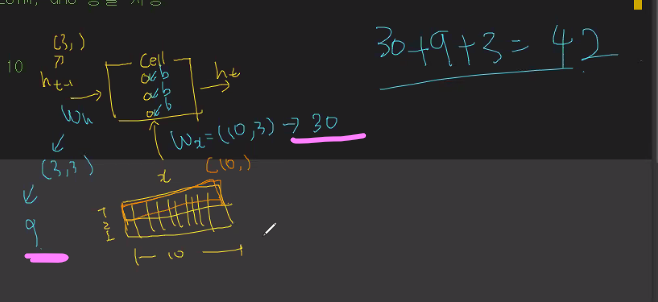

cell 3 = 뉴런 3개 -> h(t)도 3개 -> h(t)가 다시 h(t-1)로 들어감 -> w(h) = (3,3)

- input shape는 parameter개수에 영향 미치지 않음



# 네이버 영화 리뷰 분류 모델 만들기

In [15]:
# 필요 패키지
import pandas as pd
import numpy as np
import urllib.request

import matplotlib.pyplot as plt

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fbd500b7010>)

In [16]:
df_train = pd.read_table('ratings_train.txt')
df_test  = pd.read_table('ratings_test.txt')

df_train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


# 전처리 수행

In [17]:
# 중복데이터 제거
df_train['document'].nunique()

146182

약 4천개의 데이터가 중복된 리뷰임

In [18]:
df_train = df_train.drop_duplicates(subset=['document'])
df_train.nunique()

id          146183
document    146182
label            2
dtype: int64

In [19]:
# NaN값 제거

df_train = df_train.dropna(how='any') # NaN이 어디에든 들어 있으면 제거
df_train.isnull().values.sum() #NaN값의 개수를 세었을 때 0이면 NaN이 없음

0

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [21]:
# 정규식을 이용해 한글만 추출하기 (한글아닌건 없애버림, 공백제거)
df_train['documnet'] = df_train['document'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]','').str.strip()
df_train.head()


<ipython-input-21-88418a7cfda2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['documnet'] = df_train['document'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]','').str.strip()


,id,document,label,documnet
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙 진짜 짜증나네요 목소리
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2,10265843,너무재밓었다그래서보는것을추천한다,0,너무재밓었다그래서보는것을추천한다
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기구먼 솔직히 재미는 없다평점 조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...


In [22]:
# 한글을 제외하고 나머지 문자열들은 전부 비어있는 문자열 ''로 치환
# 영어만 있거나, 숫자만 있거나, 한글이 포함되지 않은 리뷰가 남아있을 수 있음

df_train.loc[df_train['document']=='', 'document'].value_counts()

Series([], Name: document, dtype: int64)

In [23]:
# 비어있는 문자열을 nan으로 치환해서 drop

df_train['documnet'].replace('',np.nan, inplace=True)
df_train = df_train.dropna(how='any')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145393 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        145393 non-null  int64 
 1   document  145393 non-null  object
 2   label     145393 non-null  int64 
 3   documnet  145393 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.5+ MB


# 토큰화 수행

In [24]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from tqdm import tqdm_notebook
from konlpy.tag import Okt

okt = Okt()

# 코퍼스 생성을 위한 리스트트
X_train = []

for sentence in tqdm_notebook(df_train['document']):
  # 형태소 분리
  temp_X = okt.morphs(sentence, stem=True, norm=True)
  X_train.append(temp_X)


<ipython-input-25-da466897d291>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(df_train['document']):


  0%|          | 0/145393 [00:00<?, ?it/s]

In [26]:
import pickle

with open('X_train.pkl','wb') as f:
  pickle.dump(X_train,f)

In [ ]:
# # 생성된 코퍼스 확인
# X_train[:3]

# 토크나이저 생성

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

### 단어 빈도수 확인
- 빈도수가 적은 단어는 사용 X
- 오타, 신조어 등 일반적으로 사용하지 않는 단어는 제거

In [ ]:
# threshold 만큼 등장하지 않은 단어들의 비율 확인
def print_freq(threshold):
  total_cnt = len(tokenizer.word_index) # 단어 개수
  rare_cnt  = 0 # 희귀 단어 개수. 등장 빈도가 threshold보다 작은 단어의 개수를 카운트

  total_freq = 0 # 훈련 데이터 전체 단어 빈도수 총 합. ex) 영화 : 3번, 재미 : 5번 -> total_freq = 8
  rare_freq  = 0 # 사용된 희귀 단어 빈도의 총 합

  # word_counts : (단어, 단어 빈도)
  for word, frequency in tokenizer.word_counts.items():

    total_freq = total_freq + frequency # 모든 단어의 빈도수 총 합 구하기

    # 희귀 단어 개수 및 등장 빈도 계산
    if frequency < threshold:
      rare_cnt += 1 # 희귀 단어 개수 +1

      rare_freq += frequency # 등장한 희귀 단어의 빈도수 총 합

  print("전체 단어 집합의 크기 : {}".format(total_cnt))
  print("등장 빈도가 {} 미만인 희귀 단어의 수 : {}".format(threshold, rare_cnt))
  print("단어 집합에서 희귀 단어의 비율 : {:.3f}%".format((rare_cnt / total_cnt) * 100))
  print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : {:.3f}%".format((rare_freq / total_freq) * 100))
  print("="*50)

  return total_cnt, rare_cnt

In [ ]:
print_freq(2)
print_freq(3)
print_freq(4)
print_freq(5)

전체 단어 집합의 크기 : 42962
등장 빈도가 2 미만인 희귀 단어의 수 : 18193
단어 집합에서 희귀 단어의 비율 : 42.347%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 0.953%
전체 단어 집합의 크기 : 42962
등장 빈도가 3 미만인 희귀 단어의 수 : 23704
단어 집합에서 희귀 단어의 비율 : 55.174%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.531%
전체 단어 집합의 크기 : 42962
등장 빈도가 4 미만인 희귀 단어의 수 : 26830
단어 집합에서 희귀 단어의 비율 : 62.451%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 2.022%
전체 단어 집합의 크기 : 42962
등장 빈도가 5 미만인 희귀 단어의 수 : 28823
단어 집합에서 희귀 단어의 비율 : 67.090%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 2.440%


(42962, 28823)

### 새로운 토크나이져 만들기
 - 희귀단어 제거, oov, padding 고려해서 토크나이저 만들기


In [ ]:
# vocab_size : 사용할 단어의 개수
# 전체 단어의 개수 - 희귀 단어의 개수
total_cnt, rare_cnt = print_freq(3)
vocab_size = total_cnt - rare_cnt + 2 # <oov>, <pad> 고려해서 +2
print(vocab_size)

전체 단어 집합의 크기 : 42962
등장 빈도가 3 미만인 희귀 단어의 수 : 23704
단어 집합에서 희귀 단어의 비율 : 55.174%
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 1.531%
19260


In [ ]:
# 희귀 단어 제거 후 토크나이져 만들기
tokenizer = Tokenizer(vocab_size, oov_token='<oov>')
tokenizer.fit_on_texts(X_train)

In [ ]:
# 정수 인코딩
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_train_encoded[:3]

[[66, 469, 29, 255, 676],
 [940, 470, 55, 622, 3, 230, 1464, 39, 971, 693, 32],
 [439, 16134, 1, 2326, 5642, 4, 240, 23, 21]]

## 비어 있는 배열 확인
- 빈도수 제한을 통해서 토크나이져를 생성하면 희귀 단어로만 이루어져 있던 코퍼스는 사용 X
- 비어있는 배열로 존재
  - [희귀, 희귀, 희귀] : [ ]

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train_encoded) if len(sentence) < 1]

In [ ]:
X_train_encoded = np.delete(X_train_encoded, drop_train, axis=0)
X_train_encoded[:3]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


array([list([66, 469, 29, 255, 676]),
       list([940, 470, 55, 622, 3, 230, 1464, 39, 971, 693, 32]),
       list([439, 16134, 1, 2326, 5642, 4, 240, 23, 21])], dtype=object)

In [ ]:
y_train = np.array(df_train['label'])
y_train = np.delete(y_train, drop_train, axis=0)
y_train

array([0, 1, 0, ..., 0, 1, 0])

## 패딩 설정하기

In [ ]:
print("리뷰의 최대 길이 : {}".format(max(len(l) for l in X_train_encoded)))
print("리뷰의 평균 길이 : {}".format(sum(map(len, X_train_encoded)) / len(X_train_encoded)))


리뷰의 최대 길이 : 78
리뷰의 평균 길이 : 13.12573507665431


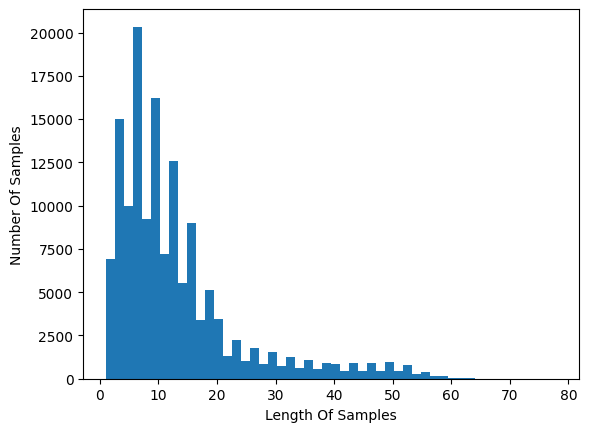

In [ ]:
# 시각화
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel("Length Of Samples")
plt.ylabel("Number Of Samples")
plt.show()

In [ ]:
def below_threshold_len(max_len):
  cnt = 0

  # max_len을 넘지 않는 문장의 개수 확인
  for s in X_train_encoded:
    if len(s) <= max_len:
      cnt += 1

  print("전체 샘플 중 길이가 {} 이하인 샘플의 비율 : {:.3f}%".format(max_len, (cnt / len(X_train_encoded) * 100)))

In [ ]:
below_threshold_len(20)
below_threshold_len(30)
below_threshold_len(40)
below_threshold_len(50)

전체 샘플 중 길이가 20 이하인 샘플의 비율 : 84.237%
전체 샘플 중 길이가 30 이하인 샘플의 비율 : 91.390%
전체 샘플 중 길이가 40 이하인 샘플의 비율 : 95.227%
전체 샘플 중 길이가 50 이하인 샘플의 비율 : 98.396%


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_encoded, maxlen=30)

In [ ]:
X_train_encoded[:3]


array([list([66, 469, 29, 255, 676]),
       list([940, 470, 55, 622, 3, 230, 1464, 39, 971, 693, 32]),
       list([439, 16134, 1, 2326, 5642, 4, 240, 23, 21])], dtype=object)

In [ ]:
X_train_padded[:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    66,   469,
           29,   255,   676],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   940,   470,    55,   622,     3,   230,  1464,    39,
          971,   693,    32],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   439, 16134,     1,  2326,  5642,     4,
          240,    23,    21]], dtype=int32)

# LSTM으로 리뷰 분류기 만들기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential([
    Embedding(vocab_size, 128), # (단어의 개수, 임베딩 차원)
    LSTM(128),
    Dense(1, activation='sigmoid')
]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2465280   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,596,993
Trainable params: 2,596,993
Non-trainable params: 0
_________________________________________________________________


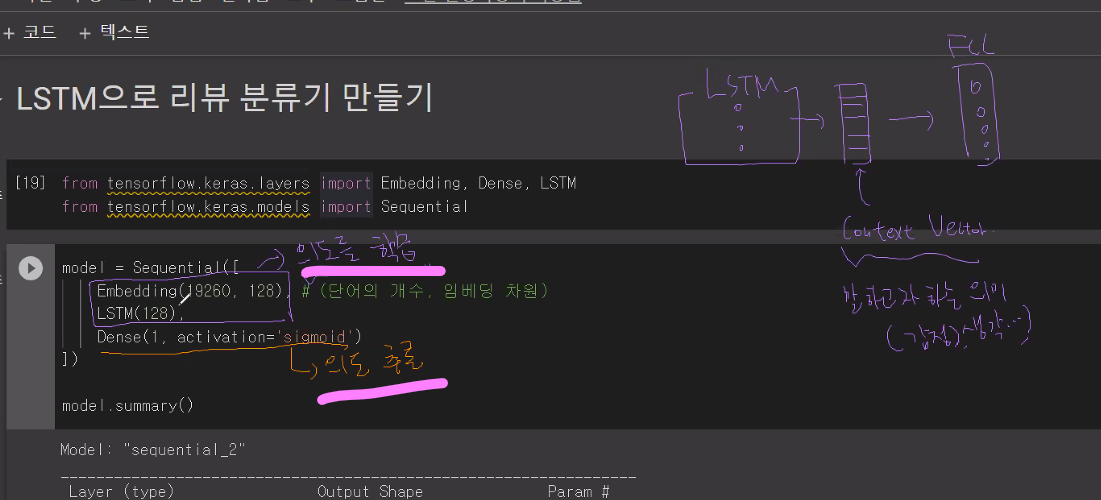

In [ ]:
import pickle
with open("./X_train_padded.pkl", 'rb') as f:
  X_train_padded = pickle.load(f)

with open("./t_train.pkl", 'rb') as f:
  t_train = pickle.load(f)

with open("./X_train.pkl", 'rb') as f:
  X_train = pickle.load(f)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 19260

# 희귀 단어 제거 후 토크나이져 만들기
tokenizer = Tokenizer(vocab_size, oov_token='<oov>')
tokenizer.fit_on_texts(X_train)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['acc']
)

In [ ]:
model.fit(
    X_train_padded,
    t_train,
    batch_size=128,
    validation_split=0.2,
    epochs=10
)

Epoch 1/10
909/909 [==============================] - 58s 55ms/step - loss: 0.3921 - acc: 0.8208 - val_loss: 0.3485 - val_acc: 0.8477
Epoch 2/10
909/909 [==============================] - 11s 12ms/step - loss: 0.3027 - acc: 0.8696 - val_loss: 0.3381 - val_acc: 0.8534
Epoch 3/10
909/909 [==============================] - 10s 11ms/step - loss: 0.2553 - acc: 0.8920 - val_loss: 0.3523 - val_acc: 0.8523
Epoch 4/10
909/909 [==============================] - 9s 10ms/step - loss: 0.2167 - acc: 0.9093 - val_loss: 0.3851 - val_acc: 0.8480
Epoch 5/10
909/909 [==============================] - 7s 8ms/step - loss: 0.1794 - acc: 0.9268 - val_loss: 0.4272 - val_acc: 0.8453
Epoch 6/10
909/909 [==============================] - 8s 9ms/step - loss: 0.1498 - acc: 0.9392 - val_loss: 0.4930 - val_acc: 0.8452
Epoch 7/10
909/909 [==============================] - 9s 10ms/step - loss: 0.1240 - acc: 0.9509 - val_loss: 0.5685 - val_acc: 0.8422
Epoch 8/10
909/909 [==============================] - 8s 8ms/step - 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 일반 자연어(새로운 문장)가 들어 왔을 때 모델을 이용한 처리
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화

  # 정수 인코딩
  encoded = tokenizer.texts_to_sequences([new_sentence])

  # 패딩
  pad_new = pad_sequences(encoded, maxlen=30)

  # 예측
  score = float(model.predict(pad_new))

  # 시그모이드를 사용했기 때문에 결과값이 0.5 넘어가면 긍정 리뷰(1)
  if score > 0.5 :
    print("{:.2f}% 확률로 긍정 리뷰 입니다.".format(score * 100))
  else:
    # 0.5 미만이면 부정 리뷰 (0)
    print("{:.2f}% 확률로 부정 리뷰 입니다.".format(( 1 - score ) * 100))